# Optimización de hiperparámetros con Optuna



XGBoost

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.preprocessing import OneHotEncoder
import pandas as pd


# Cargar los datos
df = pd.read_csv('Data/stroke_dataset.csv')

# Preparación de los datos
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Selección de características
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'] + \
           [col for col in df.columns if col.startswith(('gender_', 'ever_married_', 'work_type_', 'Residence_type_', 'smoking_status_'))]

X = df[features]
y = df['stroke']

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Informe de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       947
           1       0.12      0.26      0.16        50

    accuracy                           0.87       997
   macro avg       0.54      0.58      0.55       997
weighted avg       0.92      0.87      0.89       997


Matriz de confusión:
[[852  95]
 [ 37  13]]

ROC AUC: 0.777

Importancia de las características:
age: 0.1275
gender_Male: 0.1275
Residence_type_Rural: 0.0968
Residence_type_Urban: 0.0762
work_type_Private: 0.0731
smoking_status_Unknown: 0.0631
smoking_status_never smoked: 0.0524
hypertension: 0.0503
gender_Female: 0.0493
ever_married_No: 0.0454
work_type_Govt_job: 0.0450
bmi: 0.0352
smoking_status_formerly smoked: 0.0341
smoking_status_smokes: 0.0316
avg_glucose_level: 0.0281
work_type_children: 0.0251
work_type_Self-employed: 0.0204
heart_disease: 0.0188
ever_married_Yes: 0.0000


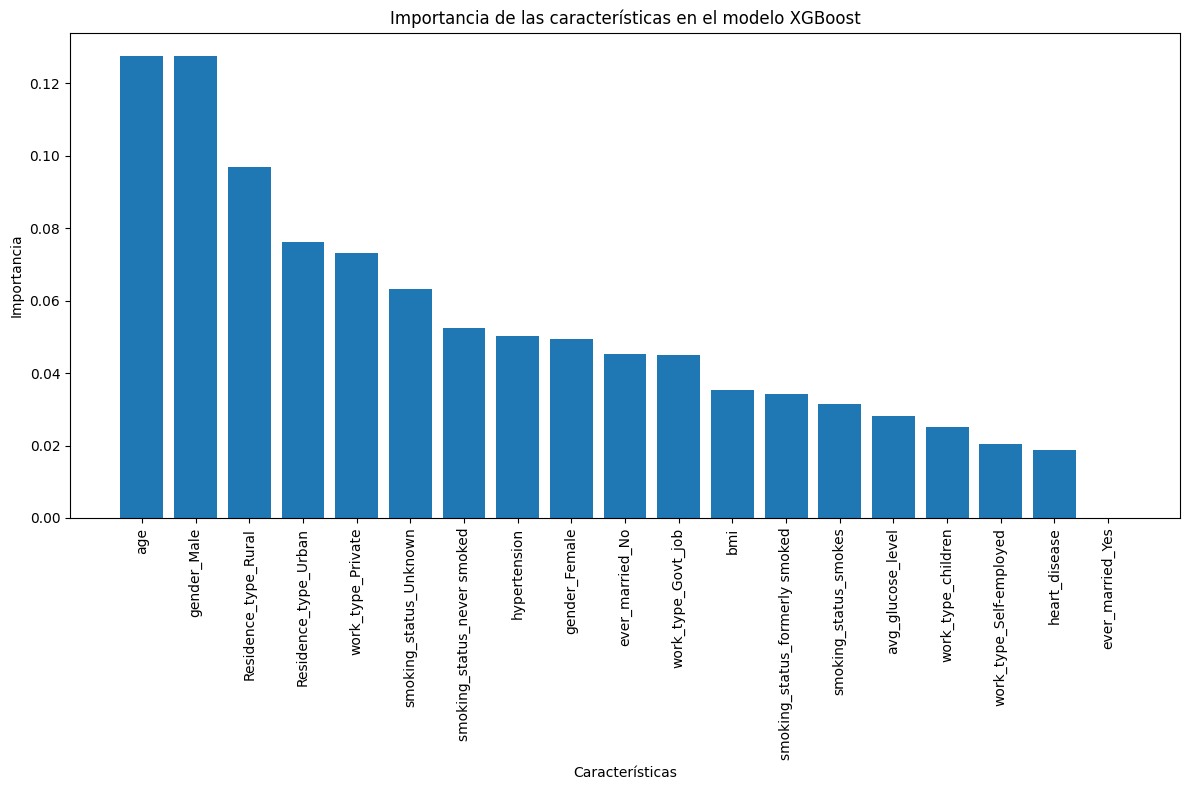

In [8]:
# Aplicar SMOTE para manejar el desbalanceo de clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Crear el modelo XGBoost con los hiperparámetros proporcionados
best_params_xgb = {
    'lambda': 0.0020347988977949456,
    'alpha': 6.065116885395498e-07,
    'colsample_bytree': 1.0,
    'subsample': 1.0,
    'learning_rate': 0.07368598010119852,
    'n_estimators': 273,
    'max_depth': 3,
    'min_child_weight': 10
}

model = XGBClassifier(**best_params_xgb, random_state=42)

# Entrenar el modelo
model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluar el modelo
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Importancia de las características
feature_importance = model.feature_importances_
feature_importance_dict = dict(zip(features, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nImportancia de las características:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Visualización de la importancia de las características
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_importance)), [imp for _, imp in sorted_features])
plt.xticks(range(len(feature_importance)), [feat for feat, _ in sorted_features], rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características en el modelo XGBoost')
plt.tight_layout()
plt.show()

Regresión lineal

#Entrenamiento del modelo

In [9]:
# Entrenar el modelo XGBoost con los mejores hiperparámetros
xgb_model_optimized = xgb.XGBClassifier(**best_params_xgb)
xgb_model_optimized.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_xgb_optimized = xgb_model_optimized.predict(X_test)

# Evaluar el rendimiento del modelo optimizado
from sklearn.metrics import classification_report

In [10]:
# Extraer importancias
importances = xgb_model_optimized.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Ordenar las características por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Importancia de las características:")
print(feature_importances)

Importancia de las características:
                           Feature  Importance
0                              age    0.263381
17     smoking_status_never smoked    0.087813
1                     hypertension    0.085492
10               work_type_Private    0.074240
13            Residence_type_Rural    0.073076
2                    heart_disease    0.069222
5                    gender_Female    0.051476
11         work_type_Self-employed    0.049839
7                  ever_married_No    0.048735
18           smoking_status_smokes    0.046902
3                avg_glucose_level    0.044981
9               work_type_Govt_job    0.038285
4                              bmi    0.035474
16  smoking_status_formerly smoked    0.031084
8                 ever_married_Yes    0.000000
6                      gender_Male    0.000000
12              work_type_children    0.000000
14            Residence_type_Urban    0.000000
15          smoking_status_Unknown    0.000000


In [11]:
# Seleccionar las 5 características más importantes
top_n = 6  # Cambia este valor según lo que desees
important_features = feature_importances.head(top_n)['Feature'].tolist()

# Filtrar los conjuntos de datos
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

import numpy as np
from sklearn.metrics import classification_report

# Entrenar el modelo XGBoost
xgb_model_optimized = xgb.XGBClassifier(**best_params_xgb)
xgb_model_optimized.fit(X_train_important, y_train)

# Obtener las probabilidades de las predicciones
y_prob_xgb_optimized = xgb_model_optimized.predict_proba(X_test_important)[:, 1]

# Definir un nuevo umbral
new_threshold = 0.165  # Ajusta este valor según sea necesario

# Clasificar las predicciones basadas en el nuevo umbral
y_pred_xgb_adjusted = (y_prob_xgb_optimized >= new_threshold).astype(int)

# Evaluar el rendimiento del modelo con el nuevo umbral
print("\nXGBoost Classification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_xgb_adjusted))

from sklearn.metrics import accuracy_score

# Predecir en el conjunto de entrenamiento
y_pred_train = xgb_model_optimized.predict(X_train_important)

# Calcular la precisión en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_pred_train)

# Calcular la precisión en el conjunto de prueba con el nuevo umbral
accuracy_test = accuracy_score(y_test, y_pred_xgb_adjusted)

# Calcular el porcentaje de overfitting
overfitting_percentage = (accuracy_train - accuracy_test) / accuracy_train * 100

# Imprimir los resultados
print(f"Accuracy en el conjunto de entrenamiento: {accuracy_train:.2f}")
print(f"Accuracy en el conjunto de prueba: {accuracy_test:.2f}")
print(f"Porcentaje de overfitting: {overfitting_percentage:.2f}%")


XGBoost Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       947
           1       0.26      0.40      0.32        50

    accuracy                           0.91       997
   macro avg       0.62      0.67      0.64       997
weighted avg       0.93      0.91      0.92       997

Accuracy en el conjunto de entrenamiento: 0.95
Accuracy en el conjunto de prueba: 0.91
Porcentaje de overfitting: 3.85%


In [12]:
xgb_model_optimized.save_model("xgboost_stroke_model_final.bin")

print("Modelo guardado como 'xgboost_stroke_model_final.bin'")

Modelo guardado como 'xgboost_stroke_model_final.bin'


c:\Users\María\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [6]:
import joblib

# Assume `model` is your trained XGBoost model
joblib.dump(xgb_model_optimized, 'xgb_model_optimized_jose.joblib')

['xgb_model_optimized_jose.joblib']